In [ ]:
!pip install pygame
!pip install JSAnimation

In [2]:
import pygame
import math

# Initialize Pygame
pygame.init()

# Constants
WIDTH, HEIGHT = 1200, 800
FPS = 60
CELL_SIZE = 40
SPEED = 3
ROTATION_SPEED = 5
SENSOR_LENGTH = 80  # Increased sensor length

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREEN = (0, 255, 0)
RED = (255, 0, 0)


#battery constant

BATTERY_WIDTH = 20
BATTERY_HEIGHT = 150
BATTERY_POSITION = (WIDTH - 50, HEIGHT // 2 - BATTERY_HEIGHT // 2)

# Define the Car class
class Car:
    def __init__(self, x, y, angle=0, max_energy=1000, energy_consumption_rate=1, recharge_rate=2):
        self.x = x
        self.y = y
        self.angle = angle
        self.path = []
        self.stuck_counter = 0
        self.max_energy = max_energy
        self.energy = max_energy  # Initial energy level
        self.energy_consumption_rate = energy_consumption_rate
        self.recharge_rate = recharge_rate

    def move(self):
        if self.energy > 0:
            self.x += SPEED * math.cos(math.radians(self.angle))
            self.y += SPEED * math.sin(math.radians(self.angle))
            self.path.append((self.x, self.y))
            self.energy -= self.energy_consumption_rate
        else:
            print("Out of energy! Charging...")
            self.energy += self.recharge_rate

    def rotate_left(self):
        self.angle += ROTATION_SPEED

    def rotate_right(self):
        self.angle -= ROTATION_SPEED

    def check_sensor(self, obstacles, angle_offset):
        sensor_x = self.x + SENSOR_LENGTH * math.cos(math.radians(self.angle + angle_offset))
        sensor_y = self.y + SENSOR_LENGTH * math.sin(math.radians(self.angle + angle_offset))

        for obstacle in obstacles:
            if obstacle.rect.collidepoint(sensor_x, sensor_y):
                return True  # Obstacle detected by the sensor

        return False  # No obstacle detected by the sensor

# Define the Obstacle class
class Obstacle:
    def __init__(self, x, y, width, height):
        self.rect = pygame.Rect(x, y, width, height)

# Initialize the Pygame window
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Robo-Car with Obstacle Detection")

clock = pygame.time.Clock()

# Create instances of Car and Obstacles
car = Car(50, 50)
finish_position = (1100, 650, 30)  # Moved finish point a bit higher

# Define the obstacles (walls and window boundaries)
obstacles = [
    Obstacle(0, 0, WIDTH, 20),
    Obstacle(0, 0, 20, HEIGHT),
    Obstacle(WIDTH - 20, 0, 20, HEIGHT),
    Obstacle(0, HEIGHT - 20, WIDTH, 20),
    Obstacle(200, 200, 20, 400),
    Obstacle(200, 200, 420, 20),  # Adjusted position and size for L-shape
    Obstacle(600, 400, 20, 400),
    Obstacle(900, -100, 20, 400),
    Obstacle(600, 400, 150, 20),
    Obstacle(600, 670, 420, 20),
]

GRID_SIZE = 40

# Main loop
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    keys = pygame.key.get_pressed()
    if keys[pygame.K_LEFT]:
        car.rotate_left()
    if keys[pygame.K_RIGHT]:
        car.rotate_right()

    # Check sensors
    front_sensor = car.check_sensor(obstacles, 0)
    left_sensor = car.check_sensor(obstacles, 45)
    right_sensor = car.check_sensor(obstacles, -45)

    # Move the car
    car.move()

    # Check energy level
    if car.energy <= 0:
        print("Out of energy! Charging...")
        pygame.font.init()
        font = pygame.font.SysFont('Arial', 50)
        text = font.render('Out of Energy!', True, RED)  # Set color to red
        screen.blit(text, (WIDTH // 2 - 150, HEIGHT // 2 - 20))
        pygame.display.flip()
        pygame.time.wait(2000)  # Wait for 2 seconds
        car.energy += car.recharge_rate


    # Check if the car is close to the finish line
    distance_to_finish = math.hypot(car.x - finish_position[0], car.y - finish_position[1])
    if distance_to_finish < finish_position[2]:
        print("Bravo! You reached your destination.")
        pygame.font.init()
        font = pygame.font.SysFont('Arial', 120)
        text = font.render('Bravo!', True, RED)  # Set color to red
        screen.blit(text, (WIDTH // 2 - 70, HEIGHT // 2 - 20))
        pygame.display.flip()
        pygame.time.wait(2000)  # Wait for 2 seconds
        running = False

    # Adjust direction based on sensor readings
    if front_sensor or left_sensor or right_sensor:
        # If any sensor detects an obstacle, stop, change direction, and reduce speed
        SPEED = 1
        car.rotate_left()

        # Check if the car is stuck (rotating in place for a certain period)
        car.stuck_counter += 1
        if car.stuck_counter > 50:
            print("The car is stuck!")
            pygame.font.init()
            font = pygame.font.SysFont('Arial', 50)
            text = font.render('Stuck!', True, RED)  # Set color to red
            screen.blit(text, (WIDTH // 2 - 70, HEIGHT // 2 - 20))
            pygame.display.flip()
            pygame.time.wait(2000)  # Wait for 2 seconds
            running = False

    else:
        SPEED = 3
        car.stuck_counter = 0

    # Update the screen
    screen.fill(WHITE)

    # DRAW Grid lines

    for x in range(0, WIDTH, GRID_SIZE):
        pygame.draw.line(screen, BLACK, (x, 0), (x, HEIGHT))
    for y in range(0, HEIGHT, GRID_SIZE):
        pygame.draw.line(screen, BLACK, (0, y), (WIDTH, y))

    for obstacle in obstacles:
        pygame.draw.rect(screen, BLACK, obstacle.rect)

    pygame.draw.rect(screen, GREEN, (car.x - CELL_SIZE // 2, car.y - CELL_SIZE // 2, CELL_SIZE, CELL_SIZE))
    pygame.draw.circle(screen, RED, finish_position[:2], finish_position[2])  # Set color to red

    # Draw battery indicator
    pygame.draw.rect(screen, GREEN, (BATTERY_POSITION[0], BATTERY_POSITION[1], BATTERY_WIDTH, BATTERY_HEIGHT))
    pygame.draw.rect(screen, RED, (BATTERY_POSITION[0], BATTERY_POSITION[1] + BATTERY_HEIGHT * (1 - car.energy / car.max_energy), BATTERY_WIDTH, BATTERY_HEIGHT * (car.energy / car.max_energy)))

    for point in car.path:
        pygame.draw.circle(screen, GREEN, (int(point[0]), int(point[1])), 2)  # Set color to green

    pygame.display.flip()
    clock.tick(FPS)

pygame.quit()


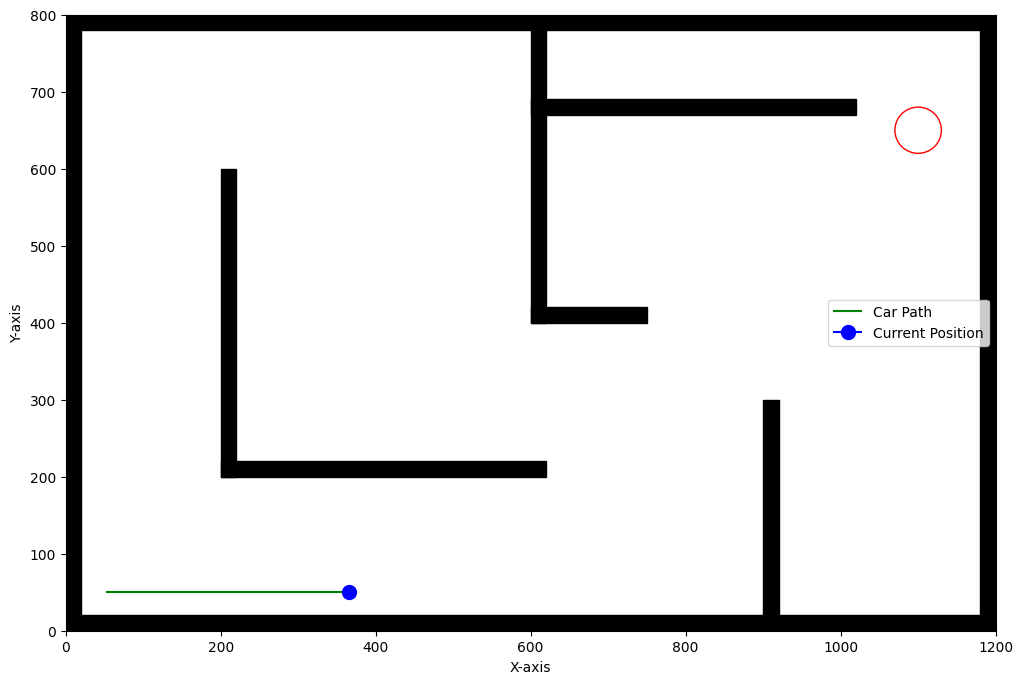

In [3]:
import matplotlib.pyplot as pl
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the obstacles
for obstacle in obstacles:
    rect = plt.Rectangle((obstacle.rect.x, obstacle.rect.y), obstacle.rect.width, obstacle.rect.height, color='black')
    ax.add_patch(rect)

# Plot the finish position
finish_circle = plt.Circle((finish_position[0], finish_position[1]), finish_position[2], color='red', fill=False)
ax.add_patch(finish_circle)

# Plot the car's path as a dotted line
path_x, path_y = zip(*car.path)
ax.plot(path_x, path_y, linestyle='dotted', color='green', label='Car Path')

# Plot the current position of the car
ax.plot(car.x, car.y, marker='o', markersize=10, color='blue', label='Current Position')

# Set axis limits and labels
ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Add a legend
ax.legend()

# Display the Matplotlib plot
plt.show()

pygame.quit()